# Recommender System & Association Rules

Il dataset è reperibile al [seguente link](https://www.kaggle.com/datasets/rishitjavia/netflix-movie-rating-dataset?select=Netflix_Dataset_Movie.csv).

## Indice
- [Analisi Statistiche](#analisi-statistiche)
- [Clustering degli Utenti](#clustering-utenti)
- [Mining delle Association Rules](#mining-delle-association-rules)
- [Applicazione delle Association Rules](#applicazione-association-rules)
    - [Raccomandazioni Cluster-Based](#raccomandazioni-cluster-based)
    - [Nesuna Ottimizzazione in Post-Processing](#nessuna-ottimizzazione-in-post-processing)
    - [Rule Base](#rule-base)
    - [FairMatch](#fairmatch)
    - [Generazione dei Suggerimenti](#generazione-dei-suggerimenti)

In [32]:
%pip install pandas
%pip install matplotlib
%pip install mlxtend
%pip install scikit-learn
%pip install scipy
%pip install pyfpgrowth
%pip install networkx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.cluster import MiniBatchKMeans
import pyfpgrowth
from collections import Counter, defaultdict
import ast
import numpy as np

In [3]:
df_movies = pd.read_csv('./dataset/Netflix_Dataset_Movie.csv')
df_ratings = pd.read_csv('./dataset/Netflix_Dataset_Rating.csv')

## Analisi Statistiche

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie_ID  17770 non-null  int64 
 1   Year      17770 non-null  int64 
 2   Name      17770 non-null  object
dtypes: int64(2), object(1)
memory usage: 416.6+ KB
None
   Movie_ID  Year                          Name
0         1  2003               Dinosaur Planet
1         2  2004    Isle of Man TT 2004 Review
2         3  1997                     Character
3         4  1994  Paula Abdul's Get Up & Dance
4         5  2004      The Rise and Fall of ECW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17337458 entries, 0 to 17337457
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   User_ID   int64
 1   Rating    int64
 2   Movie_ID  int64
dtypes: int64(3)
memory usage: 396.8 MB
None
   User_ID  Rating  Movie_ID
0   712664       5         3
1  1331154       4         3
2  263

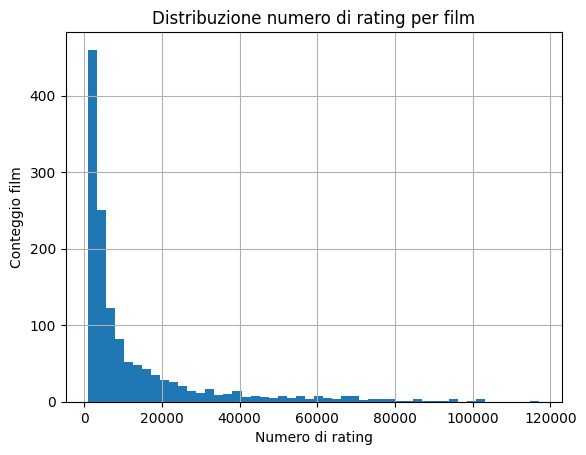

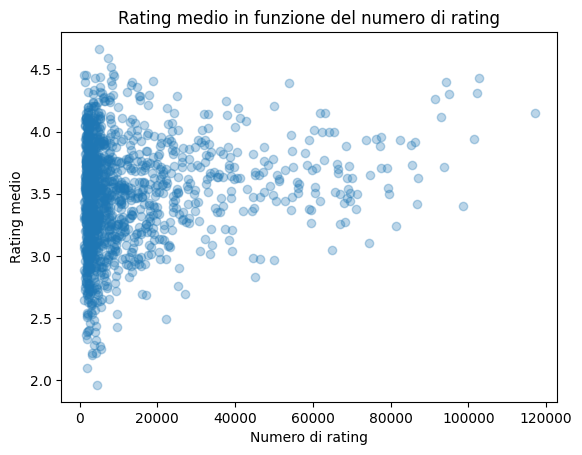

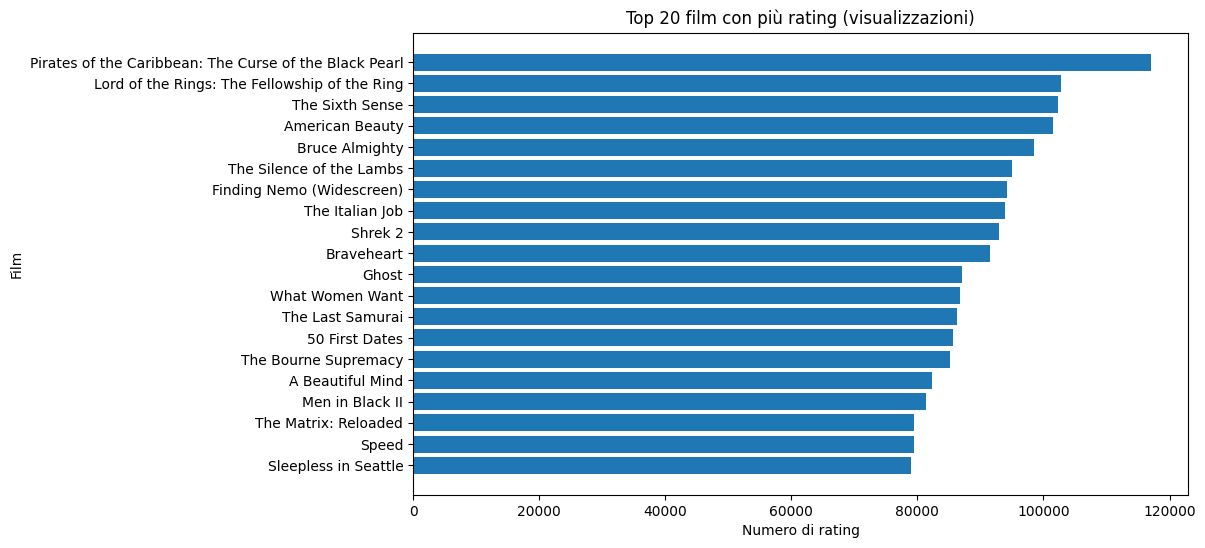

Numero totale di film: 17770
Film con almeno un rating: 1350
Film senza rating: 16420


In [10]:
print(df_movies.info())
print(df_movies.head())

print(df_ratings.info())
print(df_ratings.head())

movie_stats = (
    df_ratings
    .groupby("Movie_ID")
    .agg(
        avg_rating=("Rating", "mean"),
        num_ratings=("Rating", "count")
    )
    .reset_index()
)

num_unique_users = df_ratings['User_ID'].nunique()
print("Numero di utenti unici:", num_unique_users)

movie_stats = movie_stats.merge(df_movies, on="Movie_ID", how="left")

# Distribuzione numero di rating per film
movie_stats['num_ratings'].hist(bins=50)
plt.xlabel("Numero di rating")
plt.ylabel("Conteggio film")
plt.title("Distribuzione numero di rating per film")
plt.show()

# Rating medio vs numero di rating
plt.scatter(movie_stats['num_ratings'], movie_stats['avg_rating'], alpha=0.3)
plt.xlabel("Numero di rating")
plt.ylabel("Rating medio")
plt.title("Rating medio in funzione del numero di rating")
plt.show()

# Top 20 film più popolari
top_movies = movie_stats.sort_values("num_ratings", ascending=False).head(20)

plt.figure(figsize=(10,6))
plt.barh(top_movies["Name"], top_movies["num_ratings"])
plt.xlabel("Numero di rating")
plt.ylabel("Film")
plt.title("Top 20 film con più rating (visualizzazioni)")
plt.gca().invert_yaxis()  # così il più popolare sta in alto
plt.show()

# Statistiche dei film
total_movies = df_movies['Movie_ID'].nunique() # Numero totale di film
rated_movies = df_ratings['Movie_ID'].nunique() # Numero di film che hanno almeno un rating
unrated_movies = total_movies - rated_movies # Film senza alcun rating

print(f"Numero totale di film: {total_movies}")
print(f"Film con almeno un rating: {rated_movies}")
print(f"Film senza rating: {unrated_movies}")


Dalle analisi è emerso che:
- numero utenti: 143458
- numero film: 17770

Dopo aver preparato le transazioni, sarà necessario preparare una matrice booleana per poter applicare l'algoritmo Apriori. Tuttavia il numero di celle generate sarà 143.458 * 17.770 = 2.549.248.669 celle della matrice, che è troppo vasta ed in più sparsa. È quindi necessaria una riduzione del dataset, considerando solo gli utenti più attivi (con una lista di rating >= 50) e solo i film con più rating in assoluto (primi 1000).

Edit 1: poiché i costi computazionali sono elevati, si è deciso di seguire la strategia di **Apriori Association Rule for Course Recommender System**, che prevede una fase preliminare di clustering per raggruppare gli utenti simili. Le transazioni verranno estratte dai cluster e non dai singoli utenti.

In [5]:
# utenti attivi
active_users = df_ratings.groupby('User_ID').size()
active_users = active_users[active_users >= 50].index  # utenti con >=50 rating
print(f"Numero di utenti attivi: {len(active_users)}")

# film popolari
popular_movies = df_ratings.groupby('Movie_ID').size().sort_values(ascending=False).head(1350).index

# filtro utenti attivi e film popolari
df_filtered = df_ratings[df_ratings['User_ID'].isin(active_users) & df_ratings['Movie_ID'].isin(popular_movies)].copy()
df_filtered['Liked'] = df_filtered['Rating'] >= 3

Numero di utenti attivi: 139962


## Clustering Utenti
Prima di eseguire il clustering, è necessario creare una matrice booleana utente-film, così da poter applicare l'algoritmo k-means (calcola le distanze euclidee tra vettori). È stato utilizzato il MiniBatchKMeans per dividere gli utenti in gruppi e ottimizzare le risorse.

Edit 1: è emerso che i film unici visti dagli utenti attivi (e cioè che hanno valutato 50+ film) sono 1350. 

In [15]:
# Recupera tutti gli ID unici di utenti e film
user_ids = df_filtered['User_ID'].unique()
movie_ids = df_filtered['Movie_ID'].unique()

# Mappa gli ID originali a indici consecutivi, così da risalire agli originali se necessario
user_map = {uid:i for i, uid in enumerate(user_ids)}
movie_map = {mid:i for i, mid in enumerate(movie_ids)}

rows = df_filtered['User_ID'].map(user_map)
cols = df_filtered['Movie_ID'].map(movie_map)
data = df_filtered['Liked'].astype(int)

mat = csr_matrix((data, (rows, cols)), shape=(len(user_ids), len(movie_ids)))
print(f"Matrice booleana utenti-film di dimensione: {mat.shape}")

n_clusters = 1000
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000, random_state=42)

# array con il cluster assegnato ad ogni utente dal K-Means
cluster_labels = kmeans.fit_predict(mat)  # mat = csr_matrix utenti-film

Matrice booleana utenti-film di dimensione: (139962, 1350)


## Mining delle Association Rules
Prima di procedere all'individuazione delle regole di raccomandazione, è necessario preparare le transazioni. In questo caso:
- Ogni utente sarà considerato come un'unica transazione, quindi tutti i film che hanno ricevuto una valutazione dallo stesso utente saranno raggruppati;
- Ogni film sarà un item, ma verranno considerati solo film che hanno ricevuto un valore di Rating >= 3.

Così facendo, otterremo la lista di tutti i film piaciuti per utente.

Edit 1: poiché il numero di utenti é eccessivamente alto nonostante il filtro, si utilizzano i cluster.

In [16]:
df_filtered = df_filtered.copy() # risolve SettingWithCopyWarning

# Aggiunge la colonna 'Cluster' al DataFrame originale, che indica il cluster di appartenenza di ogni utente
df_filtered['Cluster'] = cluster_labels[df_filtered['User_ID'].map(user_map)]

transactions = (
    df_filtered[df_filtered['Liked']] # considera solo i film "piaciuti"
    .groupby('Cluster')['Movie_ID'] # raggruppa per cluster
    .apply(lambda x: list(set(x)))  # trasforma in lista di film unici
    .tolist() # converte in lista di liste
)

print(len(transactions))

993


Poiché la memoria disponibile (16GB di RAM) non è sufficiente, allora verranno rimossi rari, cioè quelli che compaiono in un numero troppo basso di transazioni.

Edit 1: Si è deciso di non rimuovere alcun film.

In [17]:
movie_counts = Counter([m for t in transactions for m in t])
min_occurrence = 5  # soglia minima di cluster in cui deve comparire
keep_movies = {m for m, c in movie_counts.items() if c >= min_occurrence}

# filtra le transazioni
transactions = [[m for m in t if m in keep_movies] for t in transactions if any(m in keep_movies for m in t)]

print(f"Numero di film rimasti dopo filtraggio: {len(keep_movies)}")
print(f"Numero di transazioni finali: {len(transactions)}")

Numero di film rimasti dopo filtraggio: 1350
Numero di transazioni finali: 993


Dal passo precedente è stata prodotta una lista di tutte le transazioni. Successivamente è necessario convertire le transazioni in una matrice booleana, affinché possa essere applicato FP-Growth. 

Si è provato con Apriori, ma scala male sulla dimensione del dataset, arrivando a limitare:
- il numero di utenti: 143458 -> 18640 (rating >= 200)
- il numero di film: 17770 -> 1000 

Edit 1: usando i cluster al posto degli utenti, si passa da 143458 -> 500. Si comincia con un Supporto del 30% (valori di Supporto più bassi causano un'aumento del tempo d'esecuzione) e una Confidenza del 60%.

Edit 2: si usa pyfpgrowth per due ragioni:
- quando la matrice è troppa grande, FP-Growth risulta più efficiente di Apriori.
- Può lavorare direttamente su liste di liste, a differenza dell'algoritmo di mlxtend.

In [ ]:
# 30% delle transazioni come soglia
support_threshold = int(0.3 * len(transactions))

# Trova pattern frequenti
patterns = pyfpgrowth.find_frequent_patterns(transactions, support_threshold)

# Genera regole (confidenza tra 0 e 1)
rules = pyfpgrowth.generate_association_rules(patterns, 0.6)

print(f"Trovati {len(patterns)} pattern frequenti")
print(f"Trovate {len(rules)} regole di associazione")


Trovati 5635 pattern frequenti
Trovate 2073 regole di associazione


I risultati prodotti vengono savlati come .csv

In [15]:
# Pattern frequenti
patterns_list = [(list(k), v) for k, v in patterns.items()]
df_patterns = pd.DataFrame(patterns_list, columns=['itemset', 'support'])
df_patterns.to_csv('./results/frequent_patterns.csv', index=False)

# Regole di associazione
rules_list = [(list(k), list(v[0]), v[1]) for k, v in rules.items()]
df_rules = pd.DataFrame(rules_list, columns=['antecedent', 'consequent', 'confidence'])
df_rules.to_csv('./results/association_rules.csv', index=False)

## Applicazione Association Rules

### Raccomandazioni Cluster-Based
La prima strategia di generazione delle raccomandazioni prevede l'utilizzo dei film più comuni all'interno del cluster di appartenenza dell'utente scelto.

In [18]:
# Raccomandazioni basate sui cluster
def recommend_from_clusters(user_id, user_item_df, cluster_labels, user_history, top_k=10):
    '''
    La funzione recupera il cluster dell'utente e raccomanda i film più popolari all'interno di quel cluster.
    Vengono raccomandati solo film che l'utente non ha ancora visto e che gli altri utenti del cluster hanno apprezzato.
    '''
    # Trova cluster dell'utente
    user_idx = user_map[user_id]
    cluster_id = cluster_labels[user_idx]
    
    cluster_users = user_item_df.iloc[np.where(cluster_labels == cluster_id)[0]] # utenti nel cluster
    movie_popularity = cluster_users.sum(axis=0).sort_values(ascending=False) # conteggio like per film
    recs = [m for m in movie_popularity.index if m not in user_history] # Filtra quelli non ancora visti

    return recs[:top_k]

### Nessuna Ottimizzazione in Post-Processing
In questa prima sezione, si cerca di applicare tutte le association rules estratte senza valutare nessun tipo di ottimizzazione. Verranno applicate due strategie differenti:
- nel primo caso si applicano le regole di associazione direttamente alla cronologia dell'utente, aggiungendo ai suggerimenti solo i film non ancora visti;
- nel secondo caso, si applicano le regole di associazione ai suggerimenti già generati, aggiungendo in coda tutti i consequent che li hanno per antecedent.

In [ ]:
rules_df = pd.read_csv("./results/association_rules.csv")
rules_df["antecedent"] = rules_df["antecedent"].apply(ast.literal_eval)
rules_df["consequent"] = rules_df["consequent"].apply(ast.literal_eval)

# trasformo in dizionario per velocizzare la ricerca
rules_dict = {}
for _, row in rules_df.iterrows():
    rules_dict[tuple(row["antecedent"])] = (row["consequent"], row["confidence"])

def apply_rules_to_history(user_history, rules_dict, top_k=10):
    """
    Applica le regole di associazione sulla cronologia dell'utente. Non aggiunge film già visti.
    Per ogni antecedent, valuta se questo fa parte della cronologia dell'utente. 
    Se sì, aggiunge il consequent alle raccomandazioni finali (se non già presente o non già visto).
    """
    recs_from_rules = []
    for antecedent, (consequent, conf) in rules_dict.items():
        if set(antecedent).issubset(set(user_history)):
            for c in consequent:
                if c not in user_history and c not in recs_from_rules:
                    recs_from_rules.append(c)
    return recs_from_rules[:top_k]

def apply_rules_to_recs(user_recs, user_history, rules_dict, top_k=10):
    '''
    Applica le regole di associazione sulle raccomandazioni iniziali. 
    Per ogni antecedent, valuta se questo fa parte delle raccomandazioni effettuate. 
    Se sì, aggiunge il consequent alle raccomandazioni finali (se non già presente o non già visto).
    '''
    final_recs = list(user_recs)
    rec_set = set(user_recs[:top_k])  # consideriamo i primi k
    history_set = set(user_history)
    
    for antecedent, (consequent, conf) in rules_dict.items():
        if set(antecedent).issubset(rec_set):  # match sull’insieme
            for c in consequent:
                if c not in final_recs and c not in history_set:
                    final_recs.append(c)
    return final_recs

### Rule Base
Approccio basato sull'articolo [Post–mining on Association Rule Bases](https://link.springer.com/chapter/10.1007/978-3-031-50485-3_2). L’articolo di Seipel mette in evidenza che le regole di associazione grezze non sono direttamente utilizzabili nei sistemi reali perché contengono rumore, ridondanze o risultano troppo generiche. Il **post-mining**, cioè l'insieme di operazioni di filtraggio, selezione e riadattamento delle regole, prevede l'uso di informazioni aggiuntive (cluster, distribuzioni, metriche extra) per capire quali regole siano utili in un contesto raccomandativo. 

Sono presenti le seguenti tre funzioni:
- ***build_movie_clusters***: quando si esegue post-mining secondo Seipel, per ogni regola è necessario trovare il cluster più rappresentativo del'antecedente (cioè il cluster in cui l'antecedente è presente per più utenti);
- ***postmine_rules***: a partire dalle regole di associazione generate, assegna ogni regola al cluster più rappresentativo;
- ***recommend_with_cluster_rules***: parte dai film più popolari nel cluster dell'utente (popolarità locale) e integra le regole post-minate, ma solo se il cluster della regola coincide con quello dell'utente.


In [ ]:
def build_movie_clusters(df_filtered, user_map, cluster_labels):
    '''
    Precalcola la mappa Movie_ID -> lista di cluster degli utenti che hanno visto il film.
    '''
    # Mappa utente -> cluster
    user_cluster_map = {u: cluster_labels[idx] for u, idx in user_map.items()}

    # Per ogni utente in df_filtered, aggiungi il suo cluster
    df_with_clusters = df_filtered.assign(cluster=df_filtered["User_ID"].map(user_cluster_map))

    # Mappa film in una lista di cluster
    movie_clusters = (
        df_with_clusters.groupby("Movie_ID")["cluster"]
        .apply(list)
        .to_dict()
    )
    return movie_clusters


def postmine_rules(rules_df, movie_clusters, min_len=2):
    '''
    Post-mining delle regole secondo Seipel:
    - rimuove antecedenti troppo piccoli (min_len)
    - assegna ogni regola al cluster più rappresentativo
    - produce un dizionario di regole
    '''
    rules_dict_post = {}

    for _, row in rules_df.iterrows():
        ant = tuple(row["antecedent"])
        cons = row["consequent"]
        conf = row["confidence"]

        if len(ant) < min_len:
            continue

        # Raccogli tutti i cluster degli item nell’antecedente
        all_clusters = [c for m in ant if m in movie_clusters for c in movie_clusters[m]]
        if not all_clusters:
            continue

        # Trova cluster più frequente
        cluster_mode = Counter(all_clusters).most_common(1)[0][0]

        rules_dict_post[ant] = (cons, conf, cluster_mode)

    return rules_dict_post

def recommend_with_cluster_rules(user_id, user_history, user_item_df, cluster_labels, user_map, rules_dict, top_k=10):
    '''
    Raccomandazioni ibride:
    - parte dai film più popolari nel cluster dell'utente (popolarità locale)
    - integra le regole post-minate, ma solo se il cluster della regola coincide con quello dell'utente
    '''
    user_idx = user_map[user_id] # recupera l'indice dell'utente nella matrice
    cluster_id = cluster_labels[user_idx] # trova il cluster dell'utente
    
    # seleziona solo gli utenti del cluster (np.where restituisce gli indici)
    cluster_users = user_item_df.iloc[np.where(cluster_labels == cluster_id)[0]]
    movie_popularity = cluster_users.sum(axis=0).sort_values(ascending=False) # conteggio like per film
    cluster_recs = [m for m in movie_popularity.index if m not in user_history][:top_k*2] # costruisce raccomandazioni sui film non visti
    

    rule_recs = {}

    for antecedent, values in rules_dict.items():
        consequent, conf, rule_cluster = values
        if rule_cluster != cluster_id: # la regola viene ignorata se il cluster non coincide
            continue  
        # controlla se tutti gli item dell'antecedente sono nella cronologia
        if all(item in user_history for item in antecedent): 
            for c in consequent:
                if c not in user_history:
                    # Usa la massima confidenza se lo stesso film compare in più regole.
                    rule_recs[c] = max(rule_recs.get(c, 0), conf)
    
    # ordina le regole per confidenza
    rules_sorted = sorted(rule_recs.items(), key=lambda x: x[1], reverse=True)
    rules_recs = [m for m, _ in rules_sorted]
    
    # Inizializza un dizionario combined per combinare le due sorgenti
    combined = {}
    alpha = 0.7  # peso delle regole post-minate (70%)
    for i, m in enumerate(cluster_recs): # Aggiunge i film del cluster alla lista finale, con punteggio inversamente proporzionale alla posizione (più in alto = più popolare)
        combined[m] = combined.get(m, 0) + (1-alpha)/(i+1)
    for i, m in enumerate(rules_recs): # Aggiunge i film suggeriti dalle regole, con punteggio inversamente proporzionale alla posizione
        combined[m] = combined.get(m, 0) + alpha/(i+1)
    
    # Ordina finale
    final_recs = sorted(combined.items(), key=lambda x: x[1], reverse=True)
    return [m for m, _ in final_recs][:top_k]

# Precalcolo fuori dal ciclo
movie_clusters = build_movie_clusters(df_filtered, user_map, cluster_labels)

# Post-mining delle regole
postmine_rules_dict = postmine_rules(rules_df, movie_clusters, min_len=2)


### FairMatch
Approccio basato sull'articolo [Fairmatch: A graph-based approach for improving aggregate diversity in recommender systems](https://dl.acm.org/doi/abs/10.1145/3340631.3394860?casa_token=0ltiJyrC9o8AAAAA:yVNVHYLhriRRZr0TZpb81HE5gEpLmSQVhukV-pDPtV_ysvsMhan0A-VRmPUD2XHqEvr0n6NCZpGu). FairMatch è un algoritmo basato su grafo che prende come input le liste di raccomandazioni generate da un modello base (per ogni utente), allargandole (cioè raccomandazioni candidate di dimensione t più grande di quella finale desiderata). Costruisce un grafo bipartito, con da un lato gli utenti e dall'altro gli item. L’algoritmo lavora per promuovere item con bassa visibilità (cioè che appaiono poco nelle raccomandazioni) ma che siano comunque vicini alla cima delle *candidate list*.

La pipeline utilizzata è la seguente:
- Passo 1: si naviga la matrice spara usando *n_user* e *n_items*. Con *max_per_item* si impone la diversità aggregata: un film non può comparire in più di questa frazione di utenti. *idx_to_user* permette di passare dagli indici della matrice agli User_ID originali.
- Passo 2: si calcola la cronologia di ogni utente considerato, dove la cronologia rappresenta tutti i film a cui l'utente ha assegnato un rating >= 3.
- Passo 3: Gli utenti vengono processati in batch di dimensione *batch_size* (10.000 di default). Questo dipende da limiti tecnici dell'hardware.
- Passo 4: per ogni utente si calcola il cluster di appartenenza, si sommano i like di tutti i film appartenenti al cluster e si ordinano in ordine decrescente per creare la candidate list (si sta sostituendo recommend_from_cluster con operazioni più veloci).
- Passo 5: si applica FairMatch, iterando sui film più popolari del cluster, escludendo quelli già visti (history) e rispettando il limite di *max_per_item*. Vengono presi i primi *candidate_k* candidati per l’utente.
- Passo 6: vengono generate le raccomandazioni finali.

A differenza della versione originale, che utilizza grafi bipartiti utenti-items, in questo caso si lavora selezionando i film più popolari nel cluster, ma tenendo conto della massima quota per film (*max_per_item_ratio*) per mantenere la diversità. Questa è un'approssimazione greedy del matching globale: se un film ha raggiunto il limite di utenti, non viene più assegnato. Questo limita la concentrazione dei film popolari senza dover fare matching globale.

L'esecuzione dura circa 00:03:30

In [ ]:
def recommend_with_fairmatch_greedy_batch(user_ids, user_item_mat, cluster_labels, df_filtered, movie_ids, top_k=10, candidate_k=30, max_per_item_ratio=0.05, batch_size=10000):
    """
    Raccomandazioni in stile FairMatch scalabili con batch, matrice sparsa e Movie_ID reali.
    """
    n_users = len(user_ids) # numero totale utenti
    n_items = user_item_mat.shape[1] # numero totale film
    max_per_item = int(max_per_item_ratio * n_users) # frazione di utenti che possono ricevere lo stesso film
    
    # Map indice matrice -> User_ID e Movie_ID originale
    idx_to_user = {i: uid for i, uid in enumerate(user_ids)}
    idx_to_movie = {i: mid for i, mid in enumerate(movie_ids)}
    
    # Dizionario per la cronologia degli utenti, per non raccomandare film già visti
    user_histories = (
        df_filtered[df_filtered["Liked"] == 1]
        .groupby("User_ID")["Movie_ID"]
        .apply(set) # trasforma in set per ricerche rapide
        .to_dict()
    )
    
    item_counts = defaultdict(int) # conteggio di quante volte ogni film è stato raccomandato
    final_recs = dict() # dizionario finale User_ID -> lista raccomandazioni
    
    # Batch processing (per ottimizzare memoria e velocità)
    for start in range(0, n_users, batch_size): # start ed end definiscono il batch
        end = min(start + batch_size, n_users)
        batch_indices = np.arange(start, end) # indici degli utenti nel batch corrente
        
        for uidx in batch_indices:
            uid = idx_to_user[uidx] # User_ID originale
            final_recs[uid] = [] # inizializza lista raccomandazioni nel dizionario per l'utente
            
            cluster_id = cluster_labels[uidx] # cluster dell'utente
            cluster_mask = (cluster_labels == cluster_id) # seleziona tutti gli utenti nello stesso cluster
            cluster_users = user_item_mat[cluster_mask] # matrice sparsa dei soli utenti nel cluster
            
            # popolarità film nel cluster
            movie_popularity = np.array(cluster_users.sum(axis=0)).ravel() # somma i like per ogni film del cluster
            candidate_idxs = np.argsort(-movie_popularity)  # ordina i film in ordine decrescente di popolarità
            
            history = user_histories.get(uid, set())
            selected = []
            # ciclo sui candidati generati per l'utente
            for idx in candidate_idxs:
                movie_id = idx_to_movie[idx]
                # se il film non è nella cronologia e non ha superato il limite, lo seleziona
                if movie_id not in history and item_counts[movie_id] < max_per_item:
                    selected.append(movie_id)
                    item_counts[movie_id] += 1 # aumenta il conteggio del film
                # se ha già selezionato abbastanza candidati, esce
                if len(selected) >= candidate_k:
                    break
            
            # prendi i primi top_k come raccomandazioni finali e li converte in interi
            final_recs[uid] = [int(mid) for mid in selected[:top_k]]
        
        # Log progresso
        print(f"Batch {start}-{end} completato.")
    
    return final_recs

fairmatch_recs_batch = recommend_with_fairmatch_greedy_batch(
    user_ids=user_ids, # array User_ID originali
    user_item_mat=mat, # matrice sparsa utenti-film
    cluster_labels=cluster_labels, # array con i cluster di ogni utente
    df_filtered=df_filtered, # dataframe filtrato (film con rating >=3)
    movie_ids=movie_ids, # array Movie_ID originali
    top_k=10, # numero di raccomandazioni finali per utente
    candidate_k=30, # numero di candidati generati per utente
    max_per_item_ratio=0.05, # massimo 5% degli utenti può ricevere lo stesso film
    batch_size=10000 # dimensione batch
)

Batch 0-10000 completato.
Batch 10000-20000 completato.
Batch 20000-30000 completato.
Batch 30000-40000 completato.
Batch 40000-50000 completato.
Batch 50000-60000 completato.


### Generazione dei Suggerimenti
In questa sezione vengono confrontati i metodi di generazione dei suggerimenti senza e con applicazione di regole di associazione. Nel caso di generazione senza regole, si utilizza il clustering effettuato nella [sezione precedente dedicata](#clustering-utenti), consigliando solo i film con piu voti nel cluster a cui l'utente è stato assegnato.

Utenti interessanti: 1473408

In [ ]:
user_id = np.random.choice(df_filtered['User_ID'].unique()) # seleziona un utente a caso
user_history = df_filtered[(df_filtered["User_ID"] == user_id) & (df_filtered["Liked"])]["Movie_ID"].tolist()

# Trasforma la matrice csr in DataFrame per comodità
user_item_df = pd.DataFrame(mat.toarray(), index=user_ids, columns=movie_ids)

# Generazione dei suggerimenti a partire dai cluser
base_recs = recommend_from_clusters(user_id, user_item_df, cluster_labels, user_history, top_k=10)

# Generazione dei suggerimenti a partire dai film già visti usando le regole di associazione
from_history_recs = apply_rules_to_history(user_history, rules_dict, top_k=10)

# Aggiunta suggerimenti a partire da quelli estratti dai cluster usando regole di associazione
final_recs = apply_rules_to_recs(base_recs, user_history, rules_dict, top_k=10)

# Utilizzo della strategia Rule Base
postmine_history_recs = recommend_with_cluster_rules(user_id, user_history, user_item_df, cluster_labels, user_map, postmine_rules_dict, top_k=10)

print("--- Raccomandazioni per l'utente", user_id, "---")
print("Clustering:   ", base_recs)
print("Da cronologia:", from_history_recs)
print("Dopo regole:  ", final_recs)
print("Da post-mine: ", postmine_history_recs)
print("FairMatch:    ", fairmatch_recs_batch[user_id])
print("User History: ", user_history)

--- Raccomandazioni per l'utente 2349300 ---
Clustering:    [1220, 3860, 1905, 607, 3938, 2200, 1428, 1798, 2372, 197]
Da cronologia: [1905, 2862]
Dopo regole:   [1220, 3860, 1905, 607, 3938, 2200, 1428, 1798, 2372, 197, 4306, 2782]
Da post-mine:  [1905, 1220, 3860, 607, 3938, 2200, 1428, 1798, 2372, 197]
User History:  [175, 313, 329, 468, 483, 808, 1145, 1255, 1267, 1289, 1307, 1509, 1542, 1561, 1665, 1703, 1843, 1962, 1975, 2152, 2173, 2452, 2457, 2612, 2617, 2800, 2874, 3106, 3138, 3254, 3368, 3418, 3427, 3433, 3463, 3579, 3624, 3638, 3648, 3670, 3782, 3825, 3903, 3917, 3936, 3962, 3972, 4123, 4149, 4216, 4432]
